In [7]:
import argparse
import logging
import os
import pprint
import threading
import time
import timeit
import traceback
import typing

os.environ["OMP_NUM_THREADS"] = "1"  # Necessary for multithreading.

import torch
from torch import multiprocessing as mp
from torch.multiprocessing import Process, Manager
from torch import nn
from torch.nn import functional as F

from torchbeast.core.environment import Environment, Vec_Environment
from torchbeast.atari_wrappers import SokobanWrapper
from torchbeast.base import BaseNet
from torchbeast.train import create_env

import gym
import gym_sokoban
import numpy as np
import math
import logging
from matplotlib import pyplot as plt
from collections import deque

logging.basicConfig(format='%(message)s', level=logging.DEBUG)
logging.getLogger('matplotlib.font_manager').disabled = True

torch.multiprocessing.set_sharing_strategy('file_system')

def get_param(net, name=None):
    keys = []
    for (k, v) in actor_wrapper.model.named_parameters(): 
        if name is None:
            print(k)
        else:
            if name == k: return v
        keys.append(k)
    return keys        

def n_step_greedy(env, net, n, temp=10.):    
    if isinstance(env, Vec_Environment):
        num_actions = env.gym_env.action_space[0].n
        bsz = len(env.gym_env.envs)
    else:
        num_actions = env.gym_env.action_space.n
        bsz = 1

    q_ret = torch.zeros(bsz, num_actions).to(device)      
    state = env.clone_state()

    for act in range(num_actions):
        obs = env.step(torch.Tensor(np.full(bsz, act)).long())      
        obs = {k:v.to(device) for k, v in obs.items()}   
        
        if n > 1:
            action, prob, sub_q_ret = n_step_greedy(env, net, n-1)
            ret = obs['reward'] + flags.discounting * torch.max(sub_q_ret, dim=1)[0] * (~obs['done']).float()
        else:
            ret = obs['reward'] + flags.discounting * net(obs)[0]['baseline'] * (~obs['done']).float()

        q_ret[:, act] = ret
        env.restore_state(state)
    
    prob = F.softmax(temp*q_ret, dim=1)
    action = torch.multinomial(prob, num_samples=1)[:, 0]
    
    return action, prob, q_ret  


<font size="5">Testing planning algo. for perfect model with bootstrapped values</font>

In [14]:
# Synchronous version of testing 

def test_n_step(n, net, env, temp=10.):
    
    print("Testing %d step planning" % n)

    returns = []
    obs = env.initial()
    eps_n_cur = 5

    while(len(returns) <= eps_n):
        cur_returns = obs['episode_return']    
        obs = {k:v.to(device) for k, v in obs.items()}
        net_out, core_state = net(obs)            
        if n == 0:
            action = net_out["action"][0]
        else:
            action, _, _ = n_step_greedy(env, net, n, temp)
        obs = env.step(action)
        if torch.any(obs['done']):
            returns.extend(cur_returns[obs['done']].numpy())
        if eps_n_cur <= len(returns) and len(returns) > 0: 
            eps_n_cur = len(returns) + 10
            print("Finish %d episode: avg. return: %.2f (+-%.2f) " % (len(returns),
                np.average(returns), np.std(returns) / np.sqrt(len(returns))))
            
    print("Finish %d episode: avg. return: %.2f (+-%.2f) " % (len(returns),
                np.average(returns), np.std(returns) / np.sqrt(len(returns))))
    return returns

bsz = 16    
eps_n = 500
device = torch.device("cuda")

# create environments

env = gym.vector.SyncVectorEnv([lambda: SokobanWrapper(gym.make("Sokoban-v0"), noop=True)] * bsz)
env = Vec_Environment(env, bsz)
num_actions = env.gym_env.action_space[0].n

# import the net

parser = argparse.ArgumentParser()
flags = parser.parse_args("".split())   
flags.discounting = 0.97
temp = 5

net = BaseNet(observation_shape=(3,80,80), num_actions=num_actions, flags=flags)  
net = net.to(device)
checkpoint = torch.load("/home/schk/RS/thinker/models/base_2.tar", map_location="cuda")
#checkpoint = torch.load("/home/schk/RS/thinker/logs/base/torchbeast-20221105-033530/model.tar", map_location="cuda")
net.load_state_dict(checkpoint["model_state_dict"]) 

# initialize net

core_state = net.initial_state(batch_size=bsz)
core_state = tuple(v.to(device) for v in core_state)
net.train(False)

all_returns = {}
for n in range(2,3):
    t = time.process_time()
    all_returns[n] = test_n_step(n, net, env, temp)
    print("Time required for %d step planning: %f" %(n, time.process_time()-t))

model size:  1095814
Testing 2 step planning
Finish 16 episode: avg. return: 0.36 (+-0.22) 
Finish 32 episode: avg. return: 0.46 (+-0.19) 
Finish 48 episode: avg. return: 0.59 (+-0.14) 
Finish 64 episode: avg. return: 0.61 (+-0.11) 


KeyboardInterrupt: 

In [15]:
# Asynchronous version of testing 

def act_m(
    flags,
    actor_index: int,
    net: torch.nn.Module,
    returns: Manager().list,
    eps_n: int,
    n: int,
    temp: float,
):    
    try:    
        #logging.info("Actor %i started", actor_index)
        gym_env = create_env(flags)
        seed = actor_index ^ int.from_bytes(os.urandom(4), byteorder="little")
        gym_env.seed(seed)
        env = Environment(gym_env)
        env_output = env.initial()  
        agent_state = net.initial_state(batch_size=1)
        net_out, unused_state = net(env_output, agent_state)      
        while True:            
            if len(returns) >= eps_n: break
            with torch.no_grad():
                net_out, agent_state = net(env_output, agent_state)                            
            if n == 0:
                action = net_out["action"]
            else:
                action, _, _ = n_step_greedy(env, net, n, temp)            
            env_output = env.step(action)           
            if env_output['done']: returns.append(ret)
            ret = env_output['episode_return'].item()        
        #logging.info("Actor %i end", actor_index)
    except KeyboardInterrupt:
        pass  # Return silently.
    except Exception as e:
        logging.error("Exception in worker process %i", actor_index)
        traceback.print_exc()
        raise e

def asy_test_n_step(n, net, flags, temp):
    
    print("Testing %d step planning" % n)

    mp.set_sharing_strategy('file_system')
    net.share_memory()
    ctx = mp.get_context()        
    returns = Manager().list()

    actor_processes = []
    for i in range(flags.num_actors):
        actor = ctx.Process(target=act_m, args=(flags, i, net, returns, eps_n, n, temp),)
        actor.start()
        actor_processes.append(actor)    

    for actor in actor_processes:
        actor.join()    

    print("Finish %d episode: avg. return: %.2f (+-%.2f)" % (len(returns),
                    np.average(returns), np.std(returns) / np.sqrt(len(returns)),))        
    return returns        
        
parser = argparse.ArgumentParser()
flags = parser.parse_args("".split())   

flags.env = "Sokoban-v0"
flags.env_disable_noop = False
flags.discounting = 0.97     
flags.num_actors = 32
bsz = 1
eps_n = 500
temp = 5
device = torch.device("cpu")

net = BaseNet(observation_shape=(3,80,80), num_actions=5, flags=flags)  
net = net.to("cpu")
checkpoint = torch.load("/home/schk/RS/thinker/models/base_2.tar", map_location="cpu")
net.load_state_dict(checkpoint["model_state_dict"]) 

all_returns = {}
for n in range(4):
    t = time.time()
    all_returns[n] = asy_test_n_step(n, net, flags, temp)
    print("Time required for %d step planning: %f" %(n, time.time()-t))

model size:  1095814
Testing 0 step planning
Finish 500 episode: avg. return: 0.27 (+-0.04)
Time required for 0 step planning: 12.629324
Testing 1 step planning
Finish 502 episode: avg. return: 0.51 (+-0.04)
Time required for 1 step planning: 74.194364
Testing 2 step planning
Finish 500 episode: avg. return: 0.74 (+-0.04)
Time required for 2 step planning: 339.732901
Testing 3 step planning
Finish 500 episode: avg. return: 0.76 (+-0.04)
Time required for 3 step planning: 1695.472523


Results (base_1.tar):
    
Testing 0 step planning <br>
Finish 512 episode: avg. return: 0.12 (+-0.06) <br>
Testing 1 step planning <br>
Finish 502 episode: avg. return: 0.61 (+-0.04) <br>
Testing 2 step planning <br>
Finish 501 episode: avg. return: 0.92 (+-0.04) <br>
Testing 3 step planning <br>
Finish 501 episode: avg. return: 1.01 (+-0.04) <br>

Results (base_2.tar):
Testing 0 step planning <br>
Finish 500 episode: avg. return: 0.27 (+-0.04) <br>
Time required for 0 step planning: 12.629324 <br>
Testing 1 step planning <br>
Finish 502 episode: avg. return: 0.51 (+-0.04) <br>
Time required for 1 step planning: 74.194364 <br>
Testing 2 step planning <br>
Finish 500 episode: avg. return: 0.74 (+-0.04) <br>
Time required for 2 step planning: 339.732901 <br>
Testing 3 step planning <br>
Finish 500 episode: avg. return: 0.76 (+-0.04) <br>
Time required for 3 step planning: 1695.472523 <br>

<font size="5">Model Training Phase</font>

In [48]:
# Generating data for learning model [RUN]

Buffers = typing.Dict[str, typing.List[torch.Tensor]]

def create_buffers_m(flags, obs_shape, num_actions) -> Buffers:
    
    seq_len = flags.seq_len
    seq_n = flags.seq_n
    specs = dict(
        frame=dict(size=(seq_len + 1, *obs_shape), dtype=torch.uint8),
        reward=dict(size=(seq_len + 1,), dtype=torch.float32),
        done=dict(size=(seq_len + 1,), dtype=torch.bool),
        truncated_done=dict(size=(seq_len + 1,), dtype=torch.bool),
        episode_return=dict(size=(seq_len + 1,), dtype=torch.float32),
        episode_step=dict(size=(seq_len + 1,), dtype=torch.int32),
        policy_logits=dict(size=(seq_len + 1, num_actions), dtype=torch.float32),
        baseline=dict(size=(seq_len + 1,), dtype=torch.float32),
        last_action=dict(size=(seq_len + 1,), dtype=torch.int64),
        action=dict(size=(seq_len + 1,), dtype=torch.int64),
        reg_loss=dict(size=(seq_len + 1,), dtype=torch.float32)
    )
    buffers: Buffers = {key: [] for key in specs}
    for _ in range(seq_n):
        for key in buffers:
            buffers[key].append(torch.empty(**specs[key]).share_memory_())
            
    return buffers

def gen_data(
    flags,
    actor_index: int,
    net: torch.nn.Module,
    buffers: Buffers,
    free_queue: mp.SimpleQueue,
):    
    try:    
        #logging.info("Actor %i started", actor_index)
        gym_env = create_env(flags)
        seed = actor_index ^ int.from_bytes(os.urandom(4), byteorder="little")
        gym_env.seed(seed)
        env = Environment(gym_env)
        env_output = env.initial()  
        agent_state = net.initial_state(batch_size=1)
        agent_output, unused_state = net(env_output, agent_state)     
        
        while True:
            index = free_queue.get()
            if index is None:
                break         

            # Write old rollout end.
            for key in env_output:
                buffers[key][index][0, ...] = env_output[key]
            for key in agent_output:
                buffers[key][index][0, ...] = agent_output[key]

            # Do new rollout.
            for t in range(flags.seq_len):
                with torch.no_grad():
                    agent_output, agent_state = net(env_output, agent_state)
                env_output = env.step(agent_output["action"])
                for key in env_output:
                    buffers[key][index][t + 1, ...] = env_output[key]
                for key in agent_output:
                    buffers[key][index][t + 1, ...] = agent_output[key]
                    
    except KeyboardInterrupt:
        pass  # Return silently.
    except Exception as e:
        logging.error("Exception in worker process %i", actor_index)
        traceback.print_exc()
        raise e
        

# Models

DOWNSCALE_C = 2

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=dilation,
        groups=groups, bias=False, dilation=dilation,)

def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class ResBlock(nn.Module):
    expansion: int = 1

    def __init__(self, inplanes, outplanes=None):
        super().__init__()
        if outplanes is None: outplanes = inplanes 
        norm_layer = nn.BatchNorm2d
        self.conv1 = conv3x3(inplanes, inplanes)
        self.bn1 = norm_layer(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(inplanes, outplanes)
        self.bn2 = norm_layer(outplanes)
        self.skip_conv = (outplanes != inplanes)
        if outplanes != inplanes:
            self.conv3 = conv1x1(inplanes, outplanes)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.skip_conv:
            out += self.conv3(identity)
        else:
            out += identity
        out = self.relu(out)
        return out
    
class FrameEncoder(nn.Module):    
    def __init__(self, num_actions, frame_channels=3):
        self.num_actions = num_actions
        super(FrameEncoder, self).__init__() 
        self.conv1 = nn.Conv2d(in_channels=frame_channels+num_actions, out_channels=128//DOWNSCALE_C, kernel_size=3, stride=2, padding=1) 
        res = nn.ModuleList([ResBlock(inplanes=128//DOWNSCALE_C) for i in range(1)]) # Deep: 2 blocks here
        self.res1 = torch.nn.Sequential(*res)
        self.conv2 = nn.Conv2d(in_channels=128//DOWNSCALE_C, out_channels=256//DOWNSCALE_C, 
                               kernel_size=3, stride=2, padding=1) 
        res = nn.ModuleList([ResBlock(inplanes=256//DOWNSCALE_C) for i in range(1)]) # Deep: 3 blocks here
        self.res2 = torch.nn.Sequential(*res)
        self.avg1 = nn.AvgPool2d(3, stride=2, padding=1)
        res = nn.ModuleList([ResBlock(inplanes=256//DOWNSCALE_C) for i in range(1)]) # Deep: 3 blocks here
        self.res3 = torch.nn.Sequential(*res)
        self.avg2 = nn.AvgPool2d(3, stride=2, padding=1)
    
    def forward(self, x, actions):        
        # input shape: B, C, H, W        
        # action shape: B 
        
        x = x.float() / 255.0    
        actions = actions.unsqueeze(-1).unsqueeze(-1).tile([1, 1, x.shape[2], x.shape[3]])        
        x = torch.concat([x, actions], dim=1)
        x = F.relu(self.conv1(x))
        x = self.res1(x)
        x = F.relu(self.conv2(x))
        x = self.res2(x)
        x = self.avg1(x)
        x = self.res3(x)
        x = self.avg2(x)
        return x
    
class DynamicModel(nn.Module):
    def __init__(self, num_actions, inplanes=256):        
        super(DynamicModel, self).__init__()
        res = nn.ModuleList([ResBlock(inplanes=inplanes) for i in range(15)] + 
                            [ResBlock(inplanes=inplanes, outplanes=inplanes*num_actions)]) # Deep: 15 blocks here
        
        self.res = torch.nn.Sequential(*res)
        self.num_actions = num_actions
    
    def forward(self, x, actions):      
        bsz, c, h, w = x.shape
        res_out = self.res(x).view(bsz, self.num_actions, c, h, w)        
        actions = actions.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        act_res_out = torch.sum(actions * res_out, dim=1)
        return act_res_out
    
class DynamicModel_(nn.Module):
    def __init__(self, num_actions, inplanes=256):        
        super(DynamicModel, self).__init__()
        res = nn.ModuleList([ResBlock(inplanes=inplanes+num_actions, outplanes=inplanes)] + [
            ResBlock(inplanes=inplanes) for i in range(4)]) # Deep: 15 blocks here
        self.res = torch.nn.Sequential(*res)
        self.num_actions = num_actions
    
    def forward(self, x, actions):      
        actions = actions.unsqueeze(-1).unsqueeze(-1).tile([1, 1, x.shape[2], x.shape[3]])        
        x = torch.concat([x, actions], dim=1)
        return self.res(x)
    
class Output_rvpi(nn.Module):   
    def __init__(self, num_actions, input_shape):         
        super(Output_rvpi, self).__init__()        
        c, h, w = input_shape
        self.conv1 = nn.Conv2d(in_channels=c, out_channels=c//2, kernel_size=3, padding='same') 
        self.conv2 = nn.Conv2d(in_channels=c//2, out_channels=c//4, kernel_size=3, padding='same') 
        fc_in = h * w * (c // 4)
        self.fc_r = nn.Linear(fc_in, 1) 
        self.fc_v = nn.Linear(fc_in, 1) 
        self.fc_logits = nn.Linear(fc_in, num_actions)         
        
    def forward(self, x):    
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, start_dim=1)
        r, v, logits = self.fc_r(x), self.fc_v(x), self.fc_logits(x)
        return r, v, logits

class Model(nn.Module):    
    def __init__(self, flags, obs_shape, num_actions):
        super(Model, self).__init__()      
        self.flags = flags
        self.obs_shape = obs_shape
        self.num_actions = num_actions          
        self.frameEncoder = FrameEncoder(num_actions=num_actions, frame_channels=obs_shape[0])
        self.dynamicModel = DynamicModel(num_actions=num_actions, inplanes=256//DOWNSCALE_C)
        self.output_rvpi = Output_rvpi(num_actions=num_actions, input_shape=(256//DOWNSCALE_C, 
                      obs_shape[1]//16, obs_shape[1]//16))
        
    def forward(self, x, actions, one_hot=False):
        # Input
        # x: frames with shape (B, C, H, W), in the form of s_t
        # actions: action (int64) with shape (k+1, B), in the form of a_{t-1}, a_{t}, a_{t+1}, .. a_{t+k-1}
        # Output
        # reward: predicted reward with shape (k, B), in the form of r_{t+1}, r_{t+2}, ..., r_{t+k}
        # value: predicted value with shape (k+1, B), in the form of v_{t}, v_{t+1}, v_{t+2}, ..., v_{t+k}
        # policy: predicted policy with shape (k+1, B), in the form of pi_{t}, pi_{t+1}, pi_{t+2}, ..., pi_{t+k}
        # encoded: encoded states with shape (k+1, B), in the form of z_t, z_{t+1}, z_{t+2}, ..., z_{t+k}
        # Recall the transition notation: s_t, a_t, r_{t+1}, s_{t+1}, ...
        
        if not one_hot:
            actions = F.one_hot(actions, self.num_actions)                
        encoded = self.frameEncoder(x, actions[0])
        return self.forward_encoded(encoded, actions[1:], one_hot=True)
    
    def forward_encoded(self, encoded, actions, one_hot=False):
        if not one_hot:
            actions = F.one_hot(actions, self.num_actions)                
        
        r, v, logits = self.output_rvpi(encoded)
        r_list, v_list, logits_list = [], [v.squeeze(-1).unsqueeze(0)], [logits.unsqueeze(0)]
        encoded_list = [encoded.unsqueeze(0)]
        
        for k in range(actions.shape[0]):            
            encoded = self.dynamicModel(encoded, actions[k])
            r, v, logits = self.output_rvpi(encoded)
            r_list.append(r.squeeze(-1).unsqueeze(0))
            v_list.append(v.squeeze(-1).unsqueeze(0))
            logits_list.append(logits.unsqueeze(0))
            encoded_list.append(encoded.unsqueeze(0))        
        
        if len(r_list) > 0:
            rs = torch.concat(r_list, dim=0)
        else:
            rs = None
            
        vs = torch.concat(v_list, dim=0)
        logits = torch.concat(logits_list, dim=0)
        encodeds = torch.concat(encoded_list, dim=0)        
        
        return rs, vs, logits, encodeds

#model = Model(flags, (3, 80, 80), num_actions=5)
#rs, vs, logits = model(torch.rand(16, 3, 80, 80), torch.ones(8, 16).long())

# functions for training models

def get_batch_m(flags, buffers: Buffers):
    batch_indices = np.random.randint(flags.seq_n, size=flags.bsz)
    time_indices = np.random.randint(flags.seq_len - flags.unroll_len, size=flags.bsz)
    batch = {key: torch.stack([buffers[key][m][time_indices[n]:time_indices[n]+flags.unroll_len+1] 
                          for n, m in enumerate(batch_indices)], dim=1) for key in buffers}
    batch = {k: t.to(device=flags.device, non_blocking=True) for k, t in batch.items()}
    return batch

def compute_cross_entropy_loss(logits, target_logits, mask):
    target_policy = F.softmax(target_logits, dim=-1)
    log_policy = F.log_softmax(logits, dim=-1)
    return -torch.sum(target_policy * log_policy * (~mask).float().unsqueeze(-1))

def compute_loss_m(model, batch):

    rs, vs, logits, _ = model(batch['frame'][0], batch['action'])
    logits = logits[:-1]

    target_rewards = batch['reward'][1:]
    target_logits = batch['policy_logits'][1:]

    target_vs = []
    target_v = model(batch['frame'][-1], batch['action'][[-1]])[1][0].detach()
    
    for t in range(vs.shape[0]-1, 0, -1):
        new_target_v = batch['reward'][t] + flags.discounting * (target_v * (~batch['done'][t]).float())# +
                           #vs[t-1] * (batch['truncated_done'][t]).float())
        target_vs.append(new_target_v.unsqueeze(0))
        target_v = new_target_v
    target_vs.reverse()
    target_vs = torch.concat(target_vs, dim=0)

    # if done on step j, r_{j}, v_{j-1}, a_{j-1} has the last valid loss 
    # rs is stored in the form of r_{t+1}, ..., r_{t+k}
    # vs is stored in the form of v_{t}, ..., v_{t+k-1}
    # logits is stored in the form of a{t}, ..., a_{t+k-1}

    done_masks = []
    done = torch.zeros(vs.shape[1]).bool().to(batch['done'].device)
    for t in range(vs.shape[0]):
        done = torch.logical_or(done, batch['done'][t])
        done_masks.append(done.unsqueeze(0))

    done_masks = torch.concat(done_masks[:-1], dim=0)
    
    # compute final loss
    huberloss = torch.nn.HuberLoss(reduction='none', delta=1.0)    
    rs_loss = torch.sum(huberloss(rs, target_rewards.detach()) * (~done_masks).float())
    #rs_loss = torch.sum(((rs - target_rewards) ** 2) * (~r_logit_done_masks).float())
    vs_loss = torch.sum(huberloss(vs[:-1], target_vs.detach()) * (~done_masks).float())
    #vs_loss = torch.sum(((vs[:-1] - target_vs) ** 2) * (~v_done_masks).float())
    logits_loss = compute_cross_entropy_loss(logits, target_logits.detach(), done_masks)
    
    return rs_loss, vs_loss, logits_loss

# n_step_greedy for testing

def n_step_greedy_model(state, action, model, n, encoded=None, temp=20.): 
    
    # Either input state, action (S_t, A_{t-1}) or the encoded Z_t
    # state / encoded in the shape of (B, C, H, W)
    # action in the shape of (B)    
    with torch.no_grad():    
      bsz = state.shape[0] if encoded is None else encoded.shape[0]
      device = state.device if encoded is None else encoded.device
      num_actions = model.num_actions    

      q_ret = torch.zeros(bsz, num_actions).to(device)        

      for act in range(num_actions):        
          new_action = torch.Tensor(np.full(bsz, act)).long().to(device)    
          if encoded is None:            
              old_new_actions = torch.concat([action.unsqueeze(0), new_action.unsqueeze(0)], dim=0)
              rs, vs, logits, encodeds = model(state, old_new_actions)
          else:
              rs, vs, logits, encodeds = model.forward_encoded(encoded, new_action.unsqueeze(0))

          if n > 1:
              action, prob, sub_q_ret = n_step_greedy_model(state=None, action=None, 
                         model=model, n=n-1, encoded=encodeds[1])
              ret = rs[0] + flags.discounting * torch.max(sub_q_ret, dim=1)[0] 
          else:
              ret = rs[0] + flags.discounting * vs[1]
          q_ret[:, act] = ret

      prob = F.softmax(temp*q_ret, dim=1)
      action = torch.multinomial(prob, num_samples=1)[:, 0]
    
    return action, prob, q_ret        
   
#n_step_greedy_model(batch['frame'][0], batch['action'][0], model, 4)  

def test_n_step_model(n, model, flags, eps_n=100, temp=20.):    
    
    print("Testing %d step planning" % n) 
    
    bsz = 100
    env = gym.vector.SyncVectorEnv([lambda: SokobanWrapper(gym.make("Sokoban-v0"), noop=True)] * bsz)
    env = Vec_Environment(env, bsz)
    num_actions = env.gym_env.action_space[0].n
    
    model.train(False)
    returns = []
    
    obs = env.initial()
    action = torch.zeros(bsz).long().to(flags.device)
    eps_n_cur = 5

    while(len(returns) <= eps_n):
        cur_returns = obs['episode_return']    
        obs = {k:v.to(flags.device) for k, v in obs.items()}
        new_action, _, _ = n_step_greedy_model(obs['frame'][0], action, model, n, None, temp)        
        obs = env.step(new_action)
        action = new_action
        if torch.any(obs['done']):
            returns.extend(cur_returns[obs['done']].numpy())
        if eps_n_cur <= len(returns) and len(returns) > 0: 
            eps_n_cur = len(returns) + 10
            #print("Finish %d episode: avg. return: %.2f (+-%.2f) " % (len(returns),
            #    np.average(returns), np.std(returns) / np.sqrt(len(returns))))
            
    returns = returns[:eps_n]
    print("Finish %d episode: avg. return: %.2f (+-%.2f) " % (len(returns),
                np.average(returns), np.std(returns) / np.sqrt(len(returns))))
    return returns

In [50]:
# Start training models

parser = argparse.ArgumentParser()
flags = parser.parse_args("".split())       

flags.env = "Sokoban-v0"
flags.env_disable_noop = False
flags.bsz = 32
flags.unroll_len = 5
flags.num_actors = 32
flags.seq_n = 1000
flags.seq_len = 200
flags.learning_rate = 0.0001
flags.loop_batch_n = 3
flags.discounting = 0.97
flags.tot_epoch = 10000
flags.grad_norm_clipping = 60

flags.device = torch.device("cuda")

# Create buffer for actors to write

mp.set_sharing_strategy('file_system')
ctx = mp.get_context()        

env = create_env(flags)
obs_shape, num_actions = env.observation_space.shape, env.action_space.n
buffers = create_buffers_m(flags, obs_shape, num_actions)
print("Buffer created successfully.")

# Initialize the model and optimizer

env = create_env(flags)
model = Model(flags, obs_shape, num_actions=num_actions).to(device=flags.device)
optimizer = torch.optim.Adam(model.parameters(), lr=flags.learning_rate)

print("model size: ", sum(p.numel() for p in model.parameters()))
for k, v in model.named_parameters(): print(k, v.numel())    
    
tot_step = int(flags.loop_batch_n * flags.seq_n * flags.seq_len / flags.bsz / flags.unroll_len) 

Buffer created successfully.
model size:  6240775
frameEncoder.conv1.weight 4608
frameEncoder.conv1.bias 64
frameEncoder.res1.0.conv1.weight 36864
frameEncoder.res1.0.bn1.weight 64
frameEncoder.res1.0.bn1.bias 64
frameEncoder.res1.0.conv2.weight 36864
frameEncoder.res1.0.bn2.weight 64
frameEncoder.res1.0.bn2.bias 64
frameEncoder.conv2.weight 73728
frameEncoder.conv2.bias 128
frameEncoder.res2.0.conv1.weight 147456
frameEncoder.res2.0.bn1.weight 128
frameEncoder.res2.0.bn1.bias 128
frameEncoder.res2.0.conv2.weight 147456
frameEncoder.res2.0.bn2.weight 128
frameEncoder.res2.0.bn2.bias 128
frameEncoder.res3.0.conv1.weight 147456
frameEncoder.res3.0.bn1.weight 128
frameEncoder.res3.0.bn1.bias 128
frameEncoder.res3.0.conv2.weight 147456
frameEncoder.res3.0.bn2.weight 128
frameEncoder.res3.0.bn2.bias 128
dynamicModel.res.0.conv1.weight 147456
dynamicModel.res.0.bn1.weight 128
dynamicModel.res.0.bn1.bias 128
dynamicModel.res.0.conv2.weight 147456
dynamicModel.res.0.bn2.weight 128
dynamicModel

In [ ]:
temp = 20

# Load the preset policy

net = BaseNet(observation_shape=(3,80,80), num_actions=5, flags=flags)  
checkpoint = torch.load("/home/schk/RS/thinker/models/base_1.tar", map_location="cpu")
net.load_state_dict(checkpoint["model_state_dict"])   
net.train(False)
net.share_memory()

# Get the actors to write on the buffer

actor_processes = []
free_queue = mp.SimpleQueue()
loss_stats = [deque(maxlen=400) for _ in range(4)]

net.train(False)
for i in range(flags.num_actors):
    actor = ctx.Process(target=gen_data, args=(flags, i, net, buffers, free_queue, ),)
    actor.start()
    actor_processes.append(actor)   
    
for m in range(flags.seq_n): free_queue.put(m)

# Start training loop    

model.train(True)
for epoch in range(flags.tot_epoch):    
    print("Batch [%d] starts" % epoch)
    while(not free_queue.empty()): time.sleep(1)
    for step in range(tot_step):
        if step == 0: 
            test_n_step_model(1, model, flags, eps_n=100, temp=temp)
            model.train(True)
        
        batch = get_batch_m(flags, buffers)
        rs_loss, vs_loss, logits_loss = compute_loss_m(model, batch)
        tot_loss = rs_loss + vs_loss + 0.05 * logits_loss
        for n, l in enumerate([tot_loss, rs_loss, vs_loss, logits_loss]):
            loss_stats[n].append(l.item())
        
        if step % 100 == 0:
            print("[%d:%d] F: %d \t tot_loss %f rs_loss %f vs_loss %f logits_loss %f" % ((
                epoch, step, (step + epoch * tot_step) * flags.bsz * flags.unroll_len,) +
                tuple(np.average(l) for l in loss_stats)))
        optimizer.zero_grad()        
        tot_loss.backward()
        optimize_params = optimizer.param_groups[0]['params']
        if flags.grad_norm_clipping > 0:
            total_norm = nn.utils.clip_grad_norm_(optimize_params, flags.grad_norm_clipping)
        optimizer.step()    
    for m in range(flags.seq_n): free_queue.put(m)
        
for _ in range(flags.num_actors): free_queue.put(None)        
for actor in actor_processes: actor.join(timeout=1)        

model size:  1095814
Batch [0] starts
Testing 1 step planning
Finish 100 episode: avg. return: -0.89 (+-0.05) 
[0:0] F: 0 	 tot_loss 14.640764 rs_loss 1.029019 vs_loss 1.043833 logits_loss 251.358246
[0:100] F: 16000 	 tot_loss 16.105540 rs_loss 1.046412 vs_loss 2.643464 logits_loss 248.313289
[0:200] F: 32000 	 tot_loss 16.298016 rs_loss 1.103860 vs_loss 2.820005 logits_loss 247.483026
[0:300] F: 48000 	 tot_loss 16.296381 rs_loss 1.098234 vs_loss 2.851524 logits_loss 246.932449
[0:400] F: 64000 	 tot_loss 16.202269 rs_loss 1.063980 vs_loss 2.811422 logits_loss 246.537344
[0:500] F: 80000 	 tot_loss 16.160249 rs_loss 1.041836 vs_loss 2.832167 logits_loss 245.724923
[0:600] F: 96000 	 tot_loss 16.122170 rs_loss 1.054497 vs_loss 2.809314 logits_loss 245.167159
[0:700] F: 112000 	 tot_loss 15.965977 rs_loss 1.031396 vs_loss 2.703742 logits_loss 244.616772
[0:800] F: 128000 	 tot_loss 15.895542 rs_loss 1.016114 vs_loss 2.666313 logits_loss 244.262317
[0:900] F: 144000 	 tot_loss 15.672175

[2:600] F: 1296000 	 tot_loss 14.845886 rs_loss 1.007950 vs_loss 2.436346 logits_loss 228.031804
[2:700] F: 1312000 	 tot_loss 14.646563 rs_loss 0.958572 vs_loss 2.296913 logits_loss 227.821552
[2:800] F: 1328000 	 tot_loss 14.556474 rs_loss 0.912315 vs_loss 2.244836 logits_loss 227.986440
[2:900] F: 1344000 	 tot_loss 14.371935 rs_loss 0.879037 vs_loss 2.119026 logits_loss 227.477449
[2:1000] F: 1360000 	 tot_loss 14.340837 rs_loss 0.875311 vs_loss 2.099806 logits_loss 227.314389
[2:1100] F: 1376000 	 tot_loss 14.320544 rs_loss 0.875194 vs_loss 2.096319 logits_loss 226.980629
[2:1200] F: 1392000 	 tot_loss 14.400485 rs_loss 0.915019 vs_loss 2.146988 logits_loss 226.769555
[2:1300] F: 1408000 	 tot_loss 14.532853 rs_loss 0.935491 vs_loss 2.270988 logits_loss 226.527466
[2:1400] F: 1424000 	 tot_loss 14.611504 rs_loss 0.930826 vs_loss 2.370307 logits_loss 226.207411
[2:1500] F: 1440000 	 tot_loss 14.828284 rs_loss 1.017202 vs_loss 2.481347 logits_loss 226.594686
[2:1600] F: 1456000 	 to

[4:1300] F: 2608000 	 tot_loss 14.372716 rs_loss 0.761748 vs_loss 2.321020 logits_loss 225.798967
[4:1400] F: 2624000 	 tot_loss 14.522732 rs_loss 0.783690 vs_loss 2.445882 logits_loss 225.863211
[4:1500] F: 2640000 	 tot_loss 14.675504 rs_loss 0.831929 vs_loss 2.572531 logits_loss 225.420866
[4:1600] F: 2656000 	 tot_loss 14.754399 rs_loss 0.823619 vs_loss 2.643042 logits_loss 225.754763
[4:1700] F: 2672000 	 tot_loss 14.685498 rs_loss 0.801195 vs_loss 2.590714 logits_loss 225.871789
[4:1800] F: 2688000 	 tot_loss 14.631081 rs_loss 0.797148 vs_loss 2.558476 logits_loss 225.509129
[4:1900] F: 2704000 	 tot_loss 14.624679 rs_loss 0.780388 vs_loss 2.568900 logits_loss 225.507794
[4:2000] F: 2720000 	 tot_loss 14.451653 rs_loss 0.785000 vs_loss 2.396265 logits_loss 225.407754
[4:2100] F: 2736000 	 tot_loss 14.370537 rs_loss 0.772310 vs_loss 2.348072 logits_loss 225.003089
[4:2200] F: 2752000 	 tot_loss 14.420027 rs_loss 0.801249 vs_loss 2.367655 logits_loss 225.022456
[4:2300] F: 2768000 

[6:2000] F: 3920000 	 tot_loss 13.861703 rs_loss 0.635288 vs_loss 2.077131 logits_loss 222.985686
[6:2100] F: 3936000 	 tot_loss 14.122073 rs_loss 0.662774 vs_loss 2.318453 logits_loss 222.816900
[6:2200] F: 3952000 	 tot_loss 14.007699 rs_loss 0.617173 vs_loss 2.238451 logits_loss 223.041506
[6:2300] F: 3968000 	 tot_loss 14.070953 rs_loss 0.625802 vs_loss 2.280424 logits_loss 223.294542
[6:2400] F: 3984000 	 tot_loss 14.113893 rs_loss 0.631159 vs_loss 2.298908 logits_loss 223.676515
[6:2500] F: 4000000 	 tot_loss 13.721252 rs_loss 0.547922 vs_loss 2.001617 logits_loss 223.434262
[6:2600] F: 4016000 	 tot_loss 13.855898 rs_loss 0.596238 vs_loss 2.105573 logits_loss 223.081746
[6:2700] F: 4032000 	 tot_loss 14.134079 rs_loss 0.676104 vs_loss 2.323981 logits_loss 222.679875
[6:2800] F: 4048000 	 tot_loss 14.572633 rs_loss 0.763855 vs_loss 2.672934 logits_loss 222.716873
[6:2900] F: 4064000 	 tot_loss 14.743299 rs_loss 0.800815 vs_loss 2.788286 logits_loss 223.083960
[6:3000] F: 4080000 

[8:2700] F: 5232000 	 tot_loss 13.783597 rs_loss 0.564036 vs_loss 2.104679 logits_loss 222.297639
[8:2800] F: 5248000 	 tot_loss 13.831311 rs_loss 0.557914 vs_loss 2.157359 logits_loss 222.320750
[8:2900] F: 5264000 	 tot_loss 14.059356 rs_loss 0.622404 vs_loss 2.322425 logits_loss 222.290533
[8:3000] F: 5280000 	 tot_loss 13.988823 rs_loss 0.584619 vs_loss 2.273310 logits_loss 222.617886
[8:3100] F: 5296000 	 tot_loss 13.921036 rs_loss 0.581884 vs_loss 2.211744 logits_loss 222.548158
[8:3200] F: 5312000 	 tot_loss 13.813422 rs_loss 0.545931 vs_loss 2.151036 logits_loss 222.329103
[8:3300] F: 5328000 	 tot_loss 13.673392 rs_loss 0.487498 vs_loss 2.055003 logits_loss 222.617814
[8:3400] F: 5344000 	 tot_loss 13.631098 rs_loss 0.507068 vs_loss 2.010950 logits_loss 222.261591
[8:3500] F: 5360000 	 tot_loss 13.884881 rs_loss 0.576771 vs_loss 2.200959 logits_loss 222.143005
[8:3600] F: 5376000 	 tot_loss 14.105633 rs_loss 0.648381 vs_loss 2.347147 logits_loss 222.202095
[8:3700] F: 5392000 

[10:3300] F: 6528000 	 tot_loss 13.433308 rs_loss 0.452504 vs_loss 1.948202 logits_loss 220.652034
[10:3400] F: 6544000 	 tot_loss 13.489810 rs_loss 0.458980 vs_loss 2.006658 logits_loss 220.483433
[10:3500] F: 6560000 	 tot_loss 13.662176 rs_loss 0.495583 vs_loss 2.160829 logits_loss 220.115261
[10:3600] F: 6576000 	 tot_loss 13.776449 rs_loss 0.527173 vs_loss 2.235413 logits_loss 220.277246
[10:3700] F: 6592000 	 tot_loss 13.592101 rs_loss 0.483752 vs_loss 2.109819 logits_loss 219.970609
Batch [11] starts
Testing 1 step planning
Finish 100 episode: avg. return: -0.65 (+-0.07) 
[11:0] F: 6600000 	 tot_loss 13.506740 rs_loss 0.481747 vs_loss 2.032847 logits_loss 219.842906
[11:100] F: 6616000 	 tot_loss 13.236214 rs_loss 0.417667 vs_loss 1.794712 logits_loss 220.476683
[11:200] F: 6632000 	 tot_loss 13.315889 rs_loss 0.423988 vs_loss 1.826167 logits_loss 221.314675
[11:300] F: 6648000 	 tot_loss 13.608262 rs_loss 0.496201 vs_loss 2.022318 logits_loss 221.794849
[11:400] F: 6664000 	 to

Testing 1 step planning
Finish 100 episode: avg. return: -0.73 (+-0.06) 
[13:0] F: 7800000 	 tot_loss 13.733178 rs_loss 0.534518 vs_loss 2.186574 logits_loss 220.241710
[13:100] F: 7816000 	 tot_loss 13.818169 rs_loss 0.575236 vs_loss 2.213371 logits_loss 220.591238
[13:200] F: 7832000 	 tot_loss 13.837067 rs_loss 0.549078 vs_loss 2.237596 logits_loss 221.007860
[13:300] F: 7848000 	 tot_loss 13.669624 rs_loss 0.505906 vs_loss 2.091334 logits_loss 221.447682
[13:400] F: 7864000 	 tot_loss 13.545986 rs_loss 0.475636 vs_loss 1.987222 logits_loss 221.662561
[13:500] F: 7880000 	 tot_loss 13.357102 rs_loss 0.426456 vs_loss 1.865593 logits_loss 221.301055
[13:600] F: 7896000 	 tot_loss 13.390432 rs_loss 0.438653 vs_loss 1.893005 logits_loss 221.175470
[13:700] F: 7912000 	 tot_loss 13.324909 rs_loss 0.433001 vs_loss 1.867699 logits_loss 220.484184
[13:800] F: 7928000 	 tot_loss 13.286562 rs_loss 0.428249 vs_loss 1.835729 logits_loss 220.451686
[13:900] F: 7944000 	 tot_loss 13.449719 rs_los

[15:500] F: 9080000 	 tot_loss 13.742848 rs_loss 0.525559 vs_loss 2.162841 logits_loss 221.088953
[15:600] F: 9096000 	 tot_loss 13.596171 rs_loss 0.487892 vs_loss 2.066227 logits_loss 220.841020
[15:700] F: 9112000 	 tot_loss 13.642038 rs_loss 0.493207 vs_loss 2.110255 logits_loss 220.771537
[15:800] F: 9128000 	 tot_loss 13.638466 rs_loss 0.481424 vs_loss 2.127822 logits_loss 220.584402
[15:900] F: 9144000 	 tot_loss 13.443426 rs_loss 0.472347 vs_loss 1.921690 logits_loss 220.987790
[15:1000] F: 9160000 	 tot_loss 13.554178 rs_loss 0.512234 vs_loss 2.008254 logits_loss 220.673817
[15:1100] F: 9176000 	 tot_loss 13.701352 rs_loss 0.540793 vs_loss 2.124863 logits_loss 220.713919
[15:1200] F: 9192000 	 tot_loss 13.657468 rs_loss 0.528618 vs_loss 2.090509 logits_loss 220.766806
[15:1300] F: 9208000 	 tot_loss 13.627916 rs_loss 0.483214 vs_loss 2.097823 logits_loss 220.937580
[15:1400] F: 9224000 	 tot_loss 13.558696 rs_loss 0.453876 vs_loss 2.028524 logits_loss 221.525912
[15:1500] F: 92

[17:1000] F: 10360000 	 tot_loss 13.882486 rs_loss 0.562997 vs_loss 2.334656 logits_loss 219.696666
[17:1100] F: 10376000 	 tot_loss 13.686943 rs_loss 0.529005 vs_loss 2.179214 logits_loss 219.574477
[17:1200] F: 10392000 	 tot_loss 13.634929 rs_loss 0.502063 vs_loss 2.142629 logits_loss 219.804742
[17:1300] F: 10408000 	 tot_loss 13.496040 rs_loss 0.475167 vs_loss 2.049255 logits_loss 219.432365
[17:1400] F: 10424000 	 tot_loss 13.510760 rs_loss 0.464105 vs_loss 2.069181 logits_loss 219.549491
[17:1500] F: 10440000 	 tot_loss 13.761804 rs_loss 0.524846 vs_loss 2.276558 logits_loss 219.207984
[17:1600] F: 10456000 	 tot_loss 13.784885 rs_loss 0.547151 vs_loss 2.297153 logits_loss 218.811614
[17:1700] F: 10472000 	 tot_loss 13.644850 rs_loss 0.516183 vs_loss 2.182456 logits_loss 218.924207
[17:1800] F: 10488000 	 tot_loss 13.476964 rs_loss 0.467920 vs_loss 2.059597 logits_loss 218.988946
[17:1900] F: 10504000 	 tot_loss 13.229572 rs_loss 0.421361 vs_loss 1.853770 logits_loss 219.088821


[19:1500] F: 11640000 	 tot_loss 13.270142 rs_loss 0.385329 vs_loss 1.905217 logits_loss 219.591917
[19:1600] F: 11656000 	 tot_loss 13.366128 rs_loss 0.409769 vs_loss 2.003100 logits_loss 219.065188
[19:1700] F: 11672000 	 tot_loss 13.194708 rs_loss 0.390058 vs_loss 1.861110 logits_loss 218.870803
[19:1800] F: 11688000 	 tot_loss 13.290670 rs_loss 0.420889 vs_loss 1.925594 logits_loss 218.883720
[19:1900] F: 11704000 	 tot_loss 13.219655 rs_loss 0.436437 vs_loss 1.861483 logits_loss 218.434707
[19:2000] F: 11720000 	 tot_loss 13.097529 rs_loss 0.418077 vs_loss 1.760091 logits_loss 218.387211
[19:2100] F: 11736000 	 tot_loss 13.106634 rs_loss 0.394130 vs_loss 1.765227 logits_loss 218.945538
[19:2200] F: 11752000 	 tot_loss 13.123908 rs_loss 0.385531 vs_loss 1.815351 logits_loss 218.460514
[19:2300] F: 11768000 	 tot_loss 13.094157 rs_loss 0.368636 vs_loss 1.800666 logits_loss 218.497102
[19:2400] F: 11784000 	 tot_loss 13.139459 rs_loss 0.387826 vs_loss 1.835970 logits_loss 218.313249


[21:2000] F: 12920000 	 tot_loss 13.632988 rs_loss 0.473807 vs_loss 2.245379 logits_loss 218.276020
[21:2100] F: 12936000 	 tot_loss 13.606561 rs_loss 0.459972 vs_loss 2.227962 logits_loss 218.372532
[21:2200] F: 12952000 	 tot_loss 13.377857 rs_loss 0.433011 vs_loss 2.025837 logits_loss 218.380180
[21:2300] F: 12968000 	 tot_loss 13.859024 rs_loss 0.547083 vs_loss 2.402549 logits_loss 218.187833
[21:2400] F: 12984000 	 tot_loss 13.602588 rs_loss 0.488473 vs_loss 2.196277 logits_loss 218.356742
[21:2500] F: 13000000 	 tot_loss 13.671454 rs_loss 0.510878 vs_loss 2.229201 logits_loss 218.627476
[21:2600] F: 13016000 	 tot_loss 13.882447 rs_loss 0.530044 vs_loss 2.422348 logits_loss 218.601089
[21:2700] F: 13032000 	 tot_loss 13.472482 rs_loss 0.453610 vs_loss 2.068227 logits_loss 219.012892
[21:2800] F: 13048000 	 tot_loss 13.762667 rs_loss 0.520741 vs_loss 2.281275 logits_loss 219.213007
[21:2900] F: 13064000 	 tot_loss 13.632032 rs_loss 0.482638 vs_loss 2.217886 logits_loss 218.630160


[23:2500] F: 14200000 	 tot_loss 12.871848 rs_loss 0.322210 vs_loss 1.633856 logits_loss 218.315627
[23:2600] F: 14216000 	 tot_loss 12.982219 rs_loss 0.348740 vs_loss 1.712709 logits_loss 218.415394
[23:2700] F: 14232000 	 tot_loss 12.867242 rs_loss 0.335788 vs_loss 1.615862 logits_loss 218.311830
[23:2800] F: 14248000 	 tot_loss 12.831781 rs_loss 0.331565 vs_loss 1.583602 logits_loss 218.332287
[23:2900] F: 14264000 	 tot_loss 12.795060 rs_loss 0.321752 vs_loss 1.556293 logits_loss 218.340280
[23:3000] F: 14280000 	 tot_loss 12.748750 rs_loss 0.312102 vs_loss 1.531509 logits_loss 218.102755
[23:3100] F: 14296000 	 tot_loss 12.707492 rs_loss 0.302601 vs_loss 1.489584 logits_loss 218.306146
[23:3200] F: 14312000 	 tot_loss 12.712898 rs_loss 0.317270 vs_loss 1.482111 logits_loss 218.270339
[23:3300] F: 14328000 	 tot_loss 12.736489 rs_loss 0.322160 vs_loss 1.487454 logits_loss 218.537498
[23:3400] F: 14344000 	 tot_loss 12.734410 rs_loss 0.318978 vs_loss 1.479328 logits_loss 218.722070


[25:3000] F: 15480000 	 tot_loss 13.270954 rs_loss 0.362549 vs_loss 1.999327 logits_loss 218.181552
[25:3100] F: 15496000 	 tot_loss 12.834583 rs_loss 0.290902 vs_loss 1.609047 logits_loss 218.692653
[25:3200] F: 15512000 	 tot_loss 12.774665 rs_loss 0.303506 vs_loss 1.560982 logits_loss 218.203541
[25:3300] F: 15528000 	 tot_loss 12.912363 rs_loss 0.324159 vs_loss 1.673499 logits_loss 218.294103
[25:3400] F: 15544000 	 tot_loss 12.878757 rs_loss 0.321591 vs_loss 1.634023 logits_loss 218.462841
[25:3500] F: 15560000 	 tot_loss 12.937125 rs_loss 0.350553 vs_loss 1.671287 logits_loss 218.305703
[25:3600] F: 15576000 	 tot_loss 12.868367 rs_loss 0.323625 vs_loss 1.617917 logits_loss 218.536521
[25:3700] F: 15592000 	 tot_loss 12.746339 rs_loss 0.305327 vs_loss 1.524967 logits_loss 218.320888
Batch [26] starts
Testing 1 step planning
Finish 100 episode: avg. return: -0.63 (+-0.07) 
[26:0] F: 15600000 	 tot_loss 12.761292 rs_loss 0.310230 vs_loss 1.545249 logits_loss 218.116247
[26:100] F: 

[27:3500] F: 16760000 	 tot_loss 13.049522 rs_loss 0.390739 vs_loss 1.755784 logits_loss 218.059977
[27:3600] F: 16776000 	 tot_loss 12.873795 rs_loss 0.349578 vs_loss 1.613630 logits_loss 218.211742
[27:3700] F: 16792000 	 tot_loss 12.809689 rs_loss 0.332684 vs_loss 1.582941 logits_loss 217.881279
Batch [28] starts
Testing 1 step planning
Finish 100 episode: avg. return: -0.68 (+-0.06) 
[28:0] F: 16800000 	 tot_loss 12.692814 rs_loss 0.303782 vs_loss 1.502640 logits_loss 217.727838
[28:100] F: 16816000 	 tot_loss 12.702055 rs_loss 0.292761 vs_loss 1.506207 logits_loss 218.061720
[28:200] F: 16832000 	 tot_loss 12.779208 rs_loss 0.309717 vs_loss 1.555731 logits_loss 218.275181
[28:300] F: 16848000 	 tot_loss 12.816971 rs_loss 0.306769 vs_loss 1.585428 logits_loss 218.495486
[28:400] F: 16864000 	 tot_loss 13.088636 rs_loss 0.360309 vs_loss 1.791888 logits_loss 218.728773
[28:500] F: 16880000 	 tot_loss 13.135225 rs_loss 0.362194 vs_loss 1.828271 logits_loss 218.895190
[28:600] F: 16896

In [37]:
for i in range(flags.num_actors):
    actor = ctx.Process(target=gen_data, args=(flags, i, net, buffers, free_queue, ),)
    actor.start()
    actor_processes.append(actor)   
    
for m in range(flags.seq_n): free_queue.put(m)

In [ ]:
free_queue.empty()

In [36]:
# stop the threads

for _ in range(flags.num_actors): free_queue.put(None)  
for actor in actor_processes: actor.join(timeout=1)   

<font size="5">Model testing / debug </font>

In [20]:
torch.save({"model_state_dict": model.state_dict(),},"../models/model_3.tar")

In [38]:
# Load trained model 

parser = argparse.ArgumentParser()
flags = parser.parse_args("".split())         
flags.env = "Sokoban-v0"
flags.env_disable_noop = False
flags.discounting = 0.97
flags.device = torch.device("cuda")
env = create_env(flags)
obs_shape, num_actions = env.observation_space.shape, env.action_space.n

model = Model(flags, obs_shape, num_actions=num_actions).to(device=flags.device)
checkpoint = torch.load("../models/model_3.tar")
model.load_state_dict(checkpoint["model_state_dict"])  

<All keys matched successfully>

In [39]:
all_returns = {}
for n in range(1,4):
    t = time.process_time()
    all_returns[n] = test_n_step_model(n, model, flags, eps_n=500, temp=20)
    print("Time required for %d step planning: %f" %(n, time.process_time()-t))

Testing 1 step planning
Finish 500 episode: avg. return: 0.38 (+-0.09) 
Time required for 1 step planning: 57.777408
Testing 2 step planning
Finish 500 episode: avg. return: 0.30 (+-0.08) 
Time required for 2 step planning: 124.808867
Testing 3 step planning
Finish 500 episode: avg. return: -0.23 (+-0.04) 
Time required for 3 step planning: 524.462036


[DEBUG:25704 pyplot:296 2022-11-05 08:45:13,666] Loaded backend module://matplotlib_inline.backend_inline version unknown.
[DEBUG:25704 pyplot:296 2022-11-05 08:45:13,668] Loaded backend module://matplotlib_inline.backend_inline version unknown.


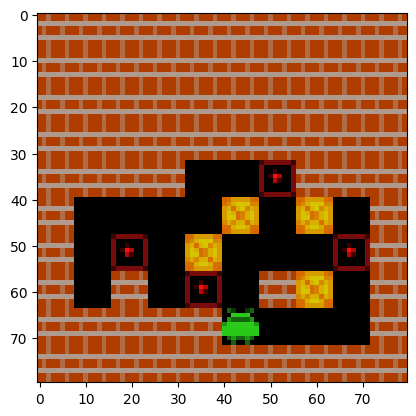

tensor([[-3.0008e-03],
        [ 1.1497e-01],
        [-1.9321e-02],
        [ 1.2748e-01],
        [ 3.2712e-01],
        [ 6.4268e-02],
        [ 1.4515e-01],
        [ 2.6107e-01],
        [-7.0306e-02],
        [-1.4643e-01],
        [-3.7516e-01],
        [-1.4747e+00],
        [-3.3316e+00],
        [-6.4096e+00]], device='cuda:0', grad_fn=<CatBackward0>) tensor([[ 0.2557],
        [ 0.4175],
        [ 0.6345],
        [ 1.5138],
        [ 3.6506],
        [ 4.5284],
        [ 5.4905],
        [ 6.8526],
        [ 8.5195],
        [10.2912],
        [14.9444],
        [26.6298],
        [38.7544],
        [42.7961],
        [44.9071]], device='cuda:0', grad_fn=<CatBackward0>)


KeyboardInterrupt: 

In [33]:
# MCTS testing

class MCTS:
    """
    Core Monte Carlo Tree Search algorithm.
    To decide on an action, we run N simulations, always starting at the root of
    the search tree and traversing the tree according to the UCB formula until we
    reach a leaf node.
    """
    def __init__(self, flags, num_actions):
        self.flags = flags
        self.num_actions = num_actions

    def run(self, model, obs, add_exploration_noise,):
        """
        At the root of the search tree we use the representation function to obtain a
        hidden state given the current observation.
        We then run a Monte Carlo Tree Search using only action sequences and the model
        learned by the network.
        Only supports a batch size of 1.        
        """
        with torch.no_grad():
            root = Node(0)
            _, root_predicted_value, policy_logits, hidden_state = model(
                obs["frame"][0], obs["last_action"], one_hot=False)
            reward = 0.
            root_predicted_value = root_predicted_value[-1].item()
            policy_logits = policy_logits[-1]
            hidden_state = hidden_state[-1]

            root.expand(num_actions, reward, policy_logits, hidden_state,)

            if add_exploration_noise:
                root.add_exploration_noise(
                    dirichlet_alpha=self.flags.root_dirichlet_alpha,
                    exploration_fraction=self.flags.root_exploration_fraction,
                )

            min_max_stats = MinMaxStats()

            max_tree_depth = 0
            
            #print("p at root:", torch.softmax(policy_logits, dim=-1))
            for k in range(self.flags.num_simulations): 
                
                #print("=======%d iteration======"%k)
                node = root
                search_path = [node]
                current_tree_depth = 0

                while node.expanded():
                    current_tree_depth += 1                    
                    action, node = self.select_child(node, min_max_stats)                    
                    search_path.append(node)
                    #print("action sel: %d" % action)
                
                #np.set_printoptions(precision=5)
                #for x in ["prior_score", "value_score", "pb_c", "prior", "visit_count"]:                    
                #    print(x, "\t", np.array([getattr(search_path[0].children[n], x) for n in range(5)]))

                # Inside the search tree we use the dynamics function to obtain the next hidden
                # state given an action and the previous hidden state
                parent = search_path[-2]     
                reward, value, policy_logits, hidden_state = model.forward_encoded(
                    parent.hidden_state, torch.tensor([[action]]).to(parent.hidden_state.device), one_hot=False)
                reward = reward[-1].item()
                value = value[-1].item()
                #print("model final output: %4f" % value)
                policy_logits = policy_logits[-1]
                hidden_state = hidden_state[-1]
                node.expand(num_actions, reward, policy_logits, hidden_state)
                self.backpropagate(search_path, value, min_max_stats)
                max_tree_depth = max(max_tree_depth, current_tree_depth)

            extra_info = {
                "max_tree_depth": max_tree_depth,
                "root_predicted_value": root_predicted_value,
            }
        return root, extra_info

    def select_child(self, node, min_max_stats):
        """
        Select the child with the highest UCB score.
        """
        max_ucb = max(
            self.ucb_score(node, child, min_max_stats)
            for action, child in node.children.items()
        )
        action = np.random.choice(
            [
                action
                for action, child in node.children.items()
                if self.ucb_score(node, child, min_max_stats) == max_ucb
            ]
        )
        return action, node.children[action]

    def ucb_score(self, parent, child, min_max_stats):
        """
        The score for a node is based on its value, plus an exploration bonus based on the prior.
        """
        pb_c = (
            math.log(
                (parent.visit_count + self.flags.pb_c_base + 1) / self.flags.pb_c_base
            )
            + self.flags.pb_c_init
        )
        pb_c *= math.sqrt(parent.visit_count) / (child.visit_count + 1)

        prior_score = pb_c * child.prior

        if child.visit_count > 0:
            # Mean value Q
            value_score = min_max_stats.normalize(
                child.reward + self.flags.discounting * child.value())
        else:
            value_score = 0
            
        child.pb_c = pb_c
        child.prior_score = prior_score
        child.value_score = value_score
        
        return prior_score + value_score

    def backpropagate(self, search_path, value, min_max_stats):
        """
        At the end of a simulation, we propagate the evaluation all the way up the tree
        to the root.
        """
        #print("bs value: %.4f" % value)
        for n, node in enumerate(reversed(search_path)):
            node.value_sum += value
            node.visit_count += 1
            min_max_stats.update(node.reward + self.flags.discounting * node.value())
            value = node.reward + self.flags.discounting * value
            #print("%d - val: %.4f r: %.4f" % (n, value, node.reward))
            #print("node value_sum %.4f" % node.value_sum)

class Node:
    def __init__(self, prior):
        self.visit_count = 0
        self.prior = prior
        self.value_sum = 0
        self.children = {}
        self.hidden_state = None
        self.reward = 0

    def expanded(self):
        return len(self.children) > 0

    def value(self):
        if self.visit_count == 0:
            return 0
        return self.value_sum / self.visit_count

    def expand(self, num_actions, reward, policy_logits, hidden_state):
        """
        We expand a node using the value, reward and policy prediction obtained from the
        neural network.
        """
        self.reward = reward
        self.hidden_state = hidden_state
        policy_values = torch.softmax(policy_logits[0], dim=0).tolist()
        for a in range(num_actions):
            self.children[a] = Node(policy_values[a])

    def add_exploration_noise(self, dirichlet_alpha, exploration_fraction):
        """
        At the start of each search, we add dirichlet noise to the prior of the root to
        encourage the search to explore new actions.
        """
        actions = list(self.children.keys())
        noise = np.random.dirichlet([dirichlet_alpha] * len(actions))
        frac = exploration_fraction
        for a, n in zip(actions, noise):
            self.children[a].prior = self.children[a].prior * (1 - frac) + n * frac

class MinMaxStats:
    """
    A class that holds the min-max values of the tree.
    """

    def __init__(self):
        self.maximum = -float("inf")
        self.minimum = float("inf")

    def update(self, value):
        self.maximum = max(self.maximum, value)
        self.minimum = min(self.minimum, value)

    def normalize(self, value):
        if self.maximum > self.minimum:
            # We normalize only when we have set the maximum and minimum values
            return (value - self.minimum) / (self.maximum - self.minimum)
        return value            

def select_action(node, temperature):
    """
    Select action according to the visit count distribution and the temperature.
    The temperature is changed dynamically with the visit_softmax_temperature function
    in the config.
    """
    visit_counts = np.array(
        [child.visit_count for child in node.children.values()], dtype="int32"
    )
    actions = [action for action in node.children.keys()]
    if temperature == 0:
        action = actions[np.argmax(visit_counts)]
    elif temperature == float("inf"):
        action = np.random.choice(actions)
    else:
        # See paper appendix Data Generation
        visit_count_distribution = visit_counts ** (1 / temperature)
        visit_count_distribution = visit_count_distribution / sum(
            visit_count_distribution
        )
        action = np.random.choice(actions, p=visit_count_distribution)
    #print("visit_counts", visit_counts)
    #print("visit_count_distribution", visit_count_distribution)
    return action
    
    
parser = argparse.ArgumentParser()      
flags = parser.parse_args([])   

env = SokobanWrapper(gym.make("Sokoban-v0"), noop=True)
env = Environment(env)
env.initial()
obs_shape, num_actions = env.gym_env.observation_space.shape, env.gym_env.action_space.n

parser = argparse.ArgumentParser()
flags = parser.parse_args([])   
flags.discounting = 0.97
flags.pb_c_init = 1.25
flags.pb_c_base = 19652
flags.root_dirichlet_alpha = 0.25
flags.root_exploration_fraction = 0.
flags.num_simulations = 3
flags.temp = 0.5
flags.device = torch.device("cuda")

eps_n = 10
eps_n_cur = 0

model = Model(flags, obs_shape, num_actions=num_actions).to(device=flags.device)
checkpoint = torch.load("../models/model_1.tar")
model.load_state_dict(checkpoint["model_state_dict"])  

obs = env.initial()
returns = []
mcts = MCTS(flags, num_actions)
obs = {k:v.to(flags.device) for k, v in obs.items()}
root, extra_info = mcts.run(model, obs, add_exploration_noise=True)   

plt.imshow(torch.swapaxes(torch.swapaxes(obs['frame'][0,0].to(
    flags.device).clone().cpu(),0,2),0,1), interpolation='nearest')
plt.show()

actions = torch.tensor([0, 1, 3, 4, 4, 4, 2, 4, 2, 2, 2, 1, 1, 1, 1]).long().to(flags.device).reshape(-1, 1)
reward, value, policy_logits, hidden_state  = model(obs["frame"][0], actions, one_hot=False)
print(reward, value)

while(len(returns) <= eps_n):
    cur_returns = obs['episode_return']    
    obs = {k:v.to(flags.device) for k, v in obs.items()}
    root, extra_info = mcts.run(model, obs, add_exploration_noise=True)    
    new_action = select_action(root, flags.temp)    
    #plt.imshow(torch.swapaxes(torch.swapaxes(obs['frame'][0,0].to(
    #flags.device).clone().cpu(),0,2),0,1), interpolation='nearest')
    #plt.show()
    #print("action selected", new_action)
    #print("===========================================")
    obs = env.step(torch.tensor([new_action]))
    if torch.any(obs['done']):
        returns.extend(cur_returns[obs['done']].numpy())
    if eps_n_cur <= len(returns) and len(returns) > 0: 
        eps_n_cur = len(returns) + 10
print("Finish %d episode: avg. return: %.2f (+-%.2f) " % (len(returns),
            np.average(returns), np.std(returns) / np.sqrt(len(returns))))

In [ ]:
# Test planning algorithm
bsz = 1
env = gym.vector.SyncVectorEnv([lambda: SokobanWrapper(gym.make("Sokoban-v0"), noop=True)] * bsz)
env = Vec_Environment(env, bsz)
obs = env.initial()
state = obs['frame'][0].to(flags.device).clone()
action = torch.zeros(bsz).long().to(flags.device)
encoded = None

In [ ]:
action = torch.Tensor([4]).long().to(flags.device)
obs = env.step(action)
state = obs['frame'][0].to(flags.device).clone()

In [ ]:
plt.imshow(torch.swapaxes(torch.swapaxes(state[0].cpu(),0,2),0,1), interpolation='nearest')
plt.show()

In [ ]:
from matplotlib import pyplot as plt
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
device = flags.device

for _ in range(1):
    plt.imshow(torch.swapaxes(torch.swapaxes(state[0].cpu(),0,2),0,1), interpolation='nearest')
    plt.show()
    ret = np.zeros((5, 5, 5))
    for i in range(5):
        for j in range(5):
            for k in range(5):
                test_action_seq = [i,j,k]
                test_action_seq = torch.Tensor(test_action_seq).unsqueeze(-1).long().to(device)  
                old_new_actions = torch.concat([action.unsqueeze(0), test_action_seq], dim=0)
                rs, vs, logits, encodeds = model(state, old_new_actions)
                ret[i, j, k] = rs[0] + rs[1] * 0.97 + rs[2] * (0.97**2) + vs[-1] * (0.97**3)
    print(np.max(ret), (np.max(ret) == ret).nonzero())    
    new_action = torch.Tensor((np.max(ret) == ret).nonzero()[0]).long().to(flags.device)
    #obs = env.step(new_action)
    #state = obs['frame'][0].to(flags.device).clone()
    #action = new_action            

In [ ]:
action, prob, q_ret = n_step_greedy_model(state, action, model, 3, encoded=None, temp=10.)
print("action: ", action)
print("prob: ", prob)
print("q_ret: ", q_ret)

In [ ]:
test_action_seq = [2,3,1]
test_action_seq = torch.Tensor(test_action_seq).unsqueeze(-1).long().to(device)  
old_new_actions = torch.concat([action.unsqueeze(0), test_action_seq], dim=0)
rs, vs, logits, encodeds = model(state, old_new_actions)
ret[i, j, k] = rs[0] + rs[1] * 0.97 + rs[2] * (0.97**2) + vs[-1] * (0.97**3)
print("rs", rs)
print("vs", vs)
print("logits", logits)
print("ret", ret[i,j,k])

In [ ]:
temp = 10.

bsz = state.shape[0]
device = state.device 
num_actions = model.num_actions    
model.train(False)

q_ret = torch.zeros(bsz, num_actions).to(device)        
rs_act = torch.zeros(bsz, num_actions).to(device)        
vs_act = torch.zeros(bsz, num_actions).to(device)        

for act in range(num_actions):        
    new_action = torch.Tensor(np.full(bsz, act)).long().to(device)    
    old_new_actions = torch.concat([action.unsqueeze(0), new_action.unsqueeze(0)], dim=0)
    rs, vs, logits, encodeds = model(state, old_new_actions)
    ret = rs[0] + flags.discounting * vs[1]
    rs_act[:, act] = rs[0]
    vs_act[:, act] = vs[1]
    q_ret[:, act] = ret

prob = F.softmax(temp*q_ret, dim=1)
action = torch.multinomial(prob, num_samples=1)[:, 0]

print("rs_act", rs_act)
print("vs_act", vs_act)
print("q_ret", q_ret)
print("prob", prob)

In [ ]:
device = flags.device
net_state = env.clone_state()

bsz = 1
temp = 10.
q_ret = torch.zeros(bsz, num_actions).to(device)      
rs_act = torch.zeros(bsz, num_actions).to(device)        
vs_act = torch.zeros(bsz, num_actions).to(device)   

net = net.to(device)

for act in range(num_actions):
    obs = env.step(torch.Tensor(np.full(bsz, act)).long())      
    obs = {k:v.to(device) for k, v in obs.items()}   
    ret = obs['reward'] + flags.discounting * net(obs)[0]['baseline'] * (~obs['done']).float()
    rs_act[:, act] = obs['reward']
    vs_act[:, act] = net(obs)[0]['baseline']
    q_ret[:, act] = ret
    env.restore_state(net_state)

prob = F.softmax(temp*q_ret, dim=1)
action = torch.multinomial(prob, num_samples=1)[:, 0]

print("rs_act", rs_act)
print("vs_act", vs_act)
print("q_ret", q_ret)
print("prob", prob)

plt.imshow(torch.swapaxes(torch.swapaxes(state[0].cpu(),0,2),0,1), interpolation='nearest')
plt.show()

In [ ]:
batch = get_batch_m(flags, buffers)
print(torch.max(batch["reward"]), (torch.max(batch["reward"]) == batch["reward"]).nonzero())
print(batch["done"].nonzero())

In [ ]:
# DEBUG LOSS

#batch = get_batch_m(flags, buffers)

model.train(False)

rs, vs, logits, _ = model(batch['frame'][0], batch['action'])
logits = logits[:-1]

target_rewards = batch['reward'][1:]
target_logits = batch['policy_logits'][1:]

target_vs = []
target_v = model(batch['frame'][-1], batch['action'][[-1]])[1][0]    

for t in range(vs.shape[0]-1, 0, -1):
    new_target_v = batch['reward'][t] + flags.discounting * (target_v * (~batch['done'][t]).float() +
                       vs[t-1] * (batch['truncated_done'][t]).float())
    target_vs.append(new_target_v.unsqueeze(0))
    target_v = new_target_v
target_vs.reverse()
target_vs = torch.concat(target_vs, dim=0)

# if done on step j, r_{j}, v_{j-1}, a_{j-1} has the last valid loss 
# rs is stored in the form of r_{t+1}, ..., r_{t+k}
# vs is stored in the form of v_{t}, ..., v_{t+k-1}
# logits is stored in the form of a{t}, ..., a_{t+k-1}

done_masks = []
done = torch.zeros(vs.shape[1]).bool().to(batch['done'].device)
for t in range(vs.shape[0]):
    done = torch.logical_or(done, batch['done'][t])
    done_masks.append(done.unsqueeze(0))

done_masks = torch.concat(done_masks[:-1], dim=0)

# compute final loss
huberloss = torch.nn.HuberLoss(reduction='none', delta=1.0)    
rs_loss = torch.sum(huberloss(rs, target_rewards) * (~done_masks).float())
#rs_loss = torch.sum(((rs - target_rewards) ** 2) * (~r_logit_done_masks).float())
vs_loss = torch.sum(huberloss(vs[:-1], target_vs) * (~done_masks).float())
#vs_loss = torch.sum(((vs[:-1] - target_vs) ** 2) * (~v_done_masks).float())
logits_loss = compute_cross_entropy_loss(logits, target_logits, done_masks)

# debug
ind = 21

target_vs = []
target_v = vs[-1]
for t in range(vs.shape[0]-1, 0, -1):        
    new_target_v = batch['reward'][t] + flags.discounting * (target_v * (~batch['done'][t]).float() +
                       vs[t-1] * (batch['truncated_done'][t]).float())
    print(t, 
          "reward %2f" % batch['reward'][t,ind].item(), 
          "bootstrap %2f" % (target_v * (~batch['done'][t]).float())[ind].item(), 
          "truncated %2f" % (vs[t-1] * (batch['truncated_done'][t]).float())[ind].item(),
          "vs[t-1] %2f" % vs[t-1][ind].item(),
          "new_targ %2f" % new_target_v[ind].item())
    target_vs.append(new_target_v.unsqueeze(0))    
    target_v = new_target_v
target_vs.reverse()
target_vs = torch.concat(target_vs, dim=0)   
print("done", batch["done"][:, ind])
print("done_masks", done_masks[:, ind])
print("vs: ", vs[:, ind])
print("target_vs: ", target_vs[:, ind])
print("reward: ", rs[:, ind])
print("target_reward: ", target_rewards[:, ind])
print("logits: ", logits[:, ind])
print("target_logits: ", target_logits[:, ind])

In [ ]:
# alt. version of computing loss by treading terminal state as absorbing state (as in MuZero)

def compute_loss_m(model, batch):

    rs, vs, logits, _ = model(batch['frame'][0], batch['action'])
    logits = logits[:-1]

    target_logits = batch['policy_logits'][1:].clone()
    target_rewards = batch['reward'][1:].clone()

    done_masks = []
    done = torch.zeros(vs.shape[1]).bool().to(batch['done'].device)

    c_logits = target_logits[0]
    c_state = batch['frame'][0]
    for t in range(vs.shape[0]-1):
        if t > 0: done = torch.logical_or(done, batch['done'][t])
        c_logits = torch.where(done.unsqueeze(-1), c_logits, target_logits[t])
        target_logits[t] = c_logits
        c_state = torch.where(done.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1), c_state, batch['frame'][t])  
        done_masks.append(done.unsqueeze(0))
    done_masks = torch.concat(done_masks, dim=0)
    done = torch.logical_or(done, batch['done'][-1])
    c_state = torch.where(done.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1), c_state, batch['frame'][-1])
    target_rewards = target_rewards * (~done_masks).float()

    target_vs = []
    target_v = model(c_state, batch['action'][[-1]])[1][0].detach()
    
    for t in range(vs.shape[0]-1, 0, -1):
        new_target_v = batch['reward'][t] + flags.discounting * target_v
        target_vs.append(new_target_v.unsqueeze(0))
        target_v = new_target_v
    target_vs.reverse()
    target_vs = torch.concat(target_vs, dim=0)
    
    # compute final loss
    huberloss = torch.nn.HuberLoss(reduction='none', delta=1.0)    
    rs_loss = torch.sum(huberloss(rs, target_rewards.detach()))
    #rs_loss = torch.sum(((rs - target_rewards) ** 2) * (~r_logit_done_masks).float())
    vs_loss = torch.sum(huberloss(vs[:-1], target_vs.detach()))
    #vs_loss = torch.sum(((vs[:-1] - target_vs) ** 2) * (~v_done_masks).float())
    logits_loss = compute_cross_entropy_loss(logits, target_logits.detach(), None)
    
    return rs_loss, vs_loss, logits_loss